In [46]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt 

#opencv code to read and display image
color_img = cv2.imread('./cat.jpeg', cv2.IMREAD_COLOR)
cv2.imshow('cute_meow', color_img)
cv2.waitKey(0)
#opencv to convert color image to grayscale image
gray_image = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)
cv2.imshow('gray', gray_image) # must have the title of image
cv2.waitKey(0)


-1

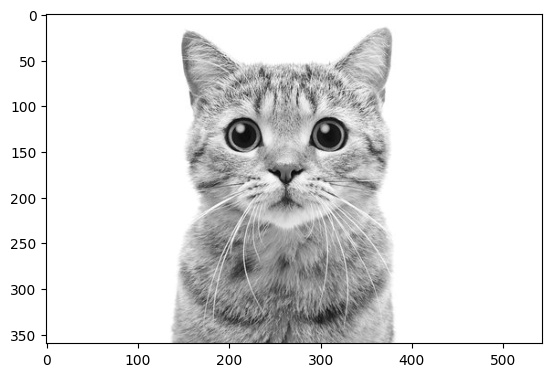

In [47]:
plt.imshow(gray_image, cmap='gray')

In [2]:
# access the pixel value at position (x, y)
x = 0; y = 0
pixelValue = gray_image[y, x]
print('Pixel value: ', pixelValue)

Pixel value:  255


In [3]:
width, height = gray_image.shape
x = int(width/2)
y = int(height/2)
pixelValue = gray_image[y, x]
print('Pixel value: ', pixelValue)

Pixel value:  156


In [4]:
color_img.shape

(360, 543, 3)

In [5]:
#Access the pixel value at the start image (Color)
width, height, channels = color_img.shape
x = 0; y = 0
pixelValue = color_img[y, x]
print('Pixel value: ', pixelValue)

Pixel value:  [255 255 255]


In [6]:
#Access the pixel at the center (color)
width, height, channels = color_img.shape
x = int(width/2)
y = int(height/2)
pixelValue = color_img[y, x]
print('Pixel value: ', pixelValue)

Pixel value:  [124 151 178]


In [7]:
import matplotlib.pyplot as plt 

def gaussian_kernel(size, sigma): # blur image
    if size % 2 == 0:
        size = size + 1
    max_point = size // 2 #both directions (x, y) maximum cell start point
    min_point = -max_point #both directions (x, y) minimum cell start point

    K = np.zeros((size, size)) #kernel matrix
    for x in range(min_point, max_point + 1):
        for y in range(min_point, max_point+1):
            value = (1/(2*np.pi * (sigma ** 2)) * np.exp((-(x ** 2 + y**2))/ (2 * (sigma ** 2))))

            K[x-min_point, y-min_point] = value

    return K
kernel = gaussian_kernel(5, 1.4)
img_gaussian = cv2.filter2D(gray_image, -1, kernel)

cv2.imshow('gassian_image', img_gaussian)
cv2.waitKey(0)


-1

In [34]:
img_gaussian = np.float64(img_gaussian) # convert image to array numpy
mask_x = np.zeros((2,1)) #[-1, 1]
mask_x[0] = -1
mask_x[1] = 1

I_x = cv2.filter2D(img_gaussian, -1, mask_x)

mask_y = mask_x.T # some note
I_y = cv2.filter2D(img_gaussian, -1, mask_y)

Gm = (I_x**2 + I_y**2) ** 0.5
Gd = np.rad2deg(np.arctan2(I_y, I_x))

cv2.imshow('I_x', I_x)
cv2.imshow('I_y', I_y)
cv2.imshow('Gm', Gm)
cv2.imshow('Gd', Gd)
cv2.waitKey(0)

-1

Text(0.5, 1.0, 'Gd')

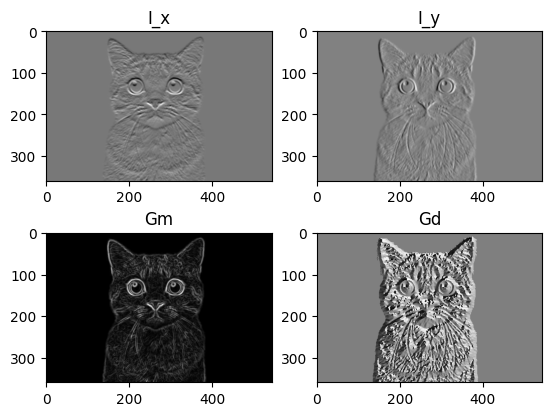

In [43]:
plt.subplot(2,2,1)
plt.imshow(I_x, cmap='gray')
plt.title('I_x')
plt.subplot(2,2,2)
plt.imshow(I_y, cmap='gray')
plt.title('I_y')
plt.subplot(2,2,3)
plt.imshow(Gm, cmap='gray')
plt.title('Gm')
plt.subplot(2,2,4)
plt.imshow(Gd, cmap='gray')
plt.title('Gd')

In [48]:
#we see that, result return by cv2.imshow() different from matplotlib.pyplot
#Because pypplot received input as 'RGB' image
#cv2 using 'BGR'
#We can use this code
#Convert BGR to RGB
#img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [16]:
def f_NMS(Gm, Gd):
    num_rows, num_cols = Gm.shape[0], Gm.shape[1]
    Gd_bins = 45 * (np.round(Gd/45))

    G_NMS = np.zeros(Gm.shape)

    neighbor_a, neighbor_b = 0., 0.

    for r in range(1, num_rows - 1):
        for c in range(1, num_cols-1):
            angle = Gd_bins[r, c]
            if angle == 180. or angle == -180. or angle == 0:
                neighbor_a, neighbor_b = Gm[r+1, c], Gm[r-1, c]
            elif angle == 90. or angle == -90.:
                neighbor_a, neighbor_b = Gm[r, c-1], Gm[r, c+1]
            elif angle == 45. or angle == -135.:
                neighbor_a, neighbor_b = Gm[r+1, c+1], Gm[r-1,c-1]
            elif angle == -45. or angle == 135.:
                neighbor_a, neighbor_b = Gm[r-1,c+1], Gm[r+1,c-1]
            else:
                print('Error')
                return
            
            if Gm[r, c] > neighbor_a and Gm[r, c] > neighbor_b:
                G_NMS[r, c] = Gm[r, c]
    return G_NMS

            

In [17]:
result_nms = f_NMS(Gm, Gd)
cv2.imshow('result_nms', result_nms)
cv2.waitKey(0)

-1

In [19]:
gray_image.max()

255

In [20]:
def threshold_edge(img, weak_pixel = 75, strong_pixel = 255):
    
    #img is a gray_image
    highT = 0.15
    lowT = 0.05

    highThreshold = img.max() *highT
    lowThreshold = highThreshold * lowT

    M, N = img.shape
    res = np.zeros((M,N), dtype=np.uint8)
    # set all elements of res are 0
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    # img is 2-dimentional so np.where returns 2 arrays
    # strong_i saves the array of first coordinate
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

    res[strong_i, strong_j] = strong_pixel
    res[weak_i, weak_j] = weak_pixel

    return res


In [32]:
result = threshold_edge(result_nms)
cv2.imshow('result image', result)
cv2.waitKey(0)

-1

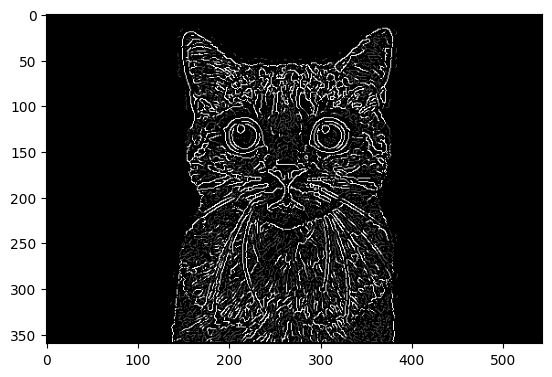

In [33]:
plt.imshow(result, cmap='gray')

In [25]:
def hysteresis(img, weak, strong=255):
    M, N = img.shape
    for i in range(1, M-1):
        for j in range(1, N-1):
            if(img[i, j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] == strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
            
    return img
result = hysteresis(result, 75, 255)
cv2.imshow('result image', result)
cv2.waitKey(0)

-1

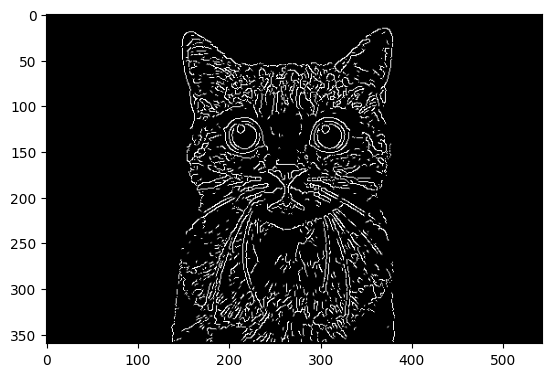

In [30]:
plt.imshow(result, cmap='gray')

In [41]:
#Edge Detection by Canny Algorithm
#Setting parameter values
t_lower = 250 # lower threshold
t_upper = 300 # Upper threshold

#Applying the Canny Edge filter
edge_canny = cv2.Canny(gray_image, t_lower, t_upper)

cv2.imshow('edge canny', edge_canny)
cv2.waitKey(0)

-1

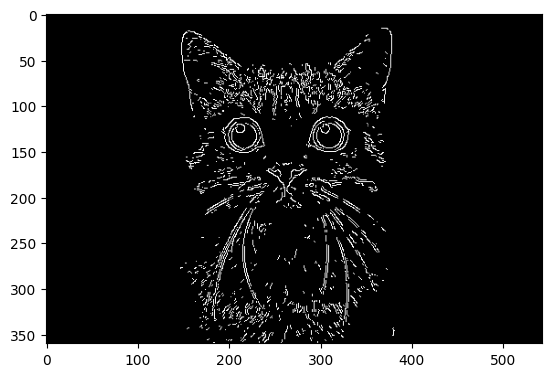

In [40]:
plt.imshow(edge_canny, cmap='gray')

In [42]:
#Edge detection by Sobel Algorithm

img_blur = cv2.GaussianBlur(gray_image, (3,3), 0)

#Sobel Edge Detection
sobelx = cv2.Sobel(src=img_blur, ddepth=-1, dx=1, dy=0, ksize=5)
# detect on the X_axis
sobely = cv2.Sobel(src=img_blur, ddepth=-1, dx=0, dy=1,ksize=5)
# detect on the Y_axis
sobelxy = cv2.Sobel(src=img_blur, ddepth=-1, dx=1, dy=1, ksize=5)
# detect on both X_axis,Y_axis

cv2.imshow('sobelx', sobelx)
cv2.imshow('sobely', sobely)
cv2.imshow('sobelxy', sobelxy)
cv2.waitKey(0)

-1

Text(0.5, 1.0, 'sobelxy')

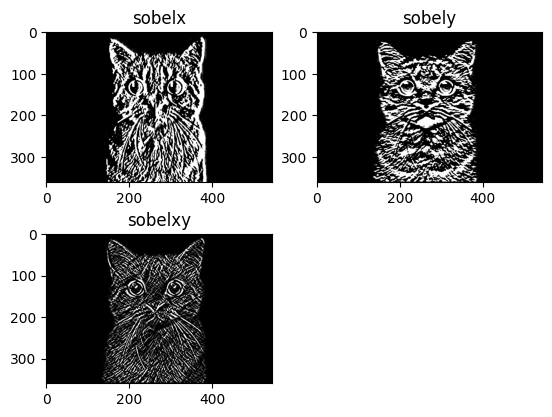

In [45]:
plt.subplot(2,2,1)
plt.imshow(sobelx, cmap='gray')
plt.title('sobelx')
plt.subplot(2,2,2)
plt.imshow(sobely, cmap='gray')
plt.title('sobely')
plt.subplot(2,2,3)
plt.imshow(sobelxy, cmap='gray')
plt.title('sobelxy')

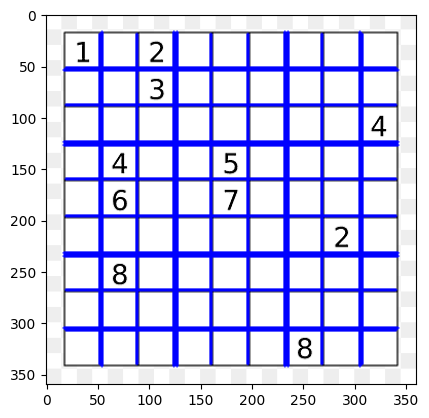

In [54]:
#Read image
image = cv2.imread('./sudoku.png')
#convert image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#use canny edged detection
edges = cv2.Canny(gray, 50, 200)

#Apply HoughLinesP method to
# to directly obtain line end points
lines_list = []
lines = cv2.HoughLinesP(
    edges, # Input edge image
    1, # Distance resolution in pixels
    np.pi/180, #Angle resolution in radians
    threshold=200, # Min number of votes for valid line
    minLineLength=5, #Min allowed length of line
    maxLineGap=10 #Max allowed gap between line for joining them
)
#Iterate over points
for points in lines:
    #Extract points nested in the list
    x1, y1, x2, y2 = points[0]
    # Draw the lines joining the points
    # On the original image
    cv2.line(image, (x1,y1), (x2,y2), (0, 0, 255),2)
    # Maintain a simples lookup list for points
    lines_list.append([(x1,y1), (x2,y2)])

#Save the result image
cv2.imshow('image', image)
cv2.waitKey(0)
plt.imshow(image)

In [60]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines


def line_detection_vectorized(image, edge_image, num_rhos=180, num_thetas=180, t_count=220):
  edge_height, edge_width = edge_image.shape[:2]
  edge_height_half, edge_width_half = edge_height / 2, edge_width / 2
  #
  d = np.sqrt(np.square(edge_height) + np.square(edge_width))
  dtheta = 180 / num_thetas
  drho = (2 * d) / num_rhos
  #
  thetas = np.arange(0, 180, step=dtheta)
  rhos = np.arange(-d, d, step=drho)
  #
  cos_thetas = np.cos(np.deg2rad(thetas))
  sin_thetas = np.sin(np.deg2rad(thetas))
  #
  accumulator = np.zeros((len(rhos), len(rhos)))
  #
  figure = plt.figure(figsize=(12, 12))
  subplot1 = figure.add_subplot(1, 4, 1)
  subplot1.imshow(image)
  subplot2 = figure.add_subplot(1, 4, 2)
  subplot2.imshow(edge_image, cmap="gray")
  subplot3 = figure.add_subplot(1, 4, 3)
  subplot3.set_facecolor((0, 0, 0))
  subplot4 = figure.add_subplot(1, 4, 4)
  subplot4.imshow(image)
  #
  edge_points = np.argwhere(edge_image != 0)
  edge_points = edge_points - np.array([[edge_height_half, edge_width_half]])
  #
  rho_values = np.matmul(edge_points, np.array([sin_thetas, cos_thetas]))
  #
  accumulator, theta_vals, rho_vals = np.histogram2d(
      np.tile(thetas, rho_values.shape[0]),
      rho_values.ravel(),
      bins=[thetas, rhos]
  )
  accumulator = np.transpose(accumulator)
  lines = np.argwhere(accumulator > t_count)
  rho_idxs, theta_idxs = lines[:, 0], lines[:, 1]
  r, t = rhos[rho_idxs], thetas[theta_idxs]

  for ys in rho_values:
    subplot3.plot(thetas, ys, color="white", alpha=0.05)

  subplot3.plot([t], [r], color="yellow", marker='o')

  for line in lines:
    y, x = line
    rho = rhos[y]
    theta = thetas[x]
    a = np.cos(np.deg2rad(theta))
    b = np.sin(np.deg2rad(theta))
    x0 = (a * rho) + edge_width_half
    y0 = (b * rho) + edge_height_half
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    subplot3.plot([theta], [rho], marker='o', color="yellow")
    subplot4.add_line(mlines.Line2D([x1, x2], [y1, y2]))

  subplot3.invert_yaxis()
  subplot3.invert_xaxis()

  subplot1.title.set_text("Original Image")
  subplot2.title.set_text("Edge Image")
  subplot3.title.set_text("Hough Space")
  subplot4.title.set_text("Detected Lines")
  plt.show()
  return accumulator, rhos, thetas

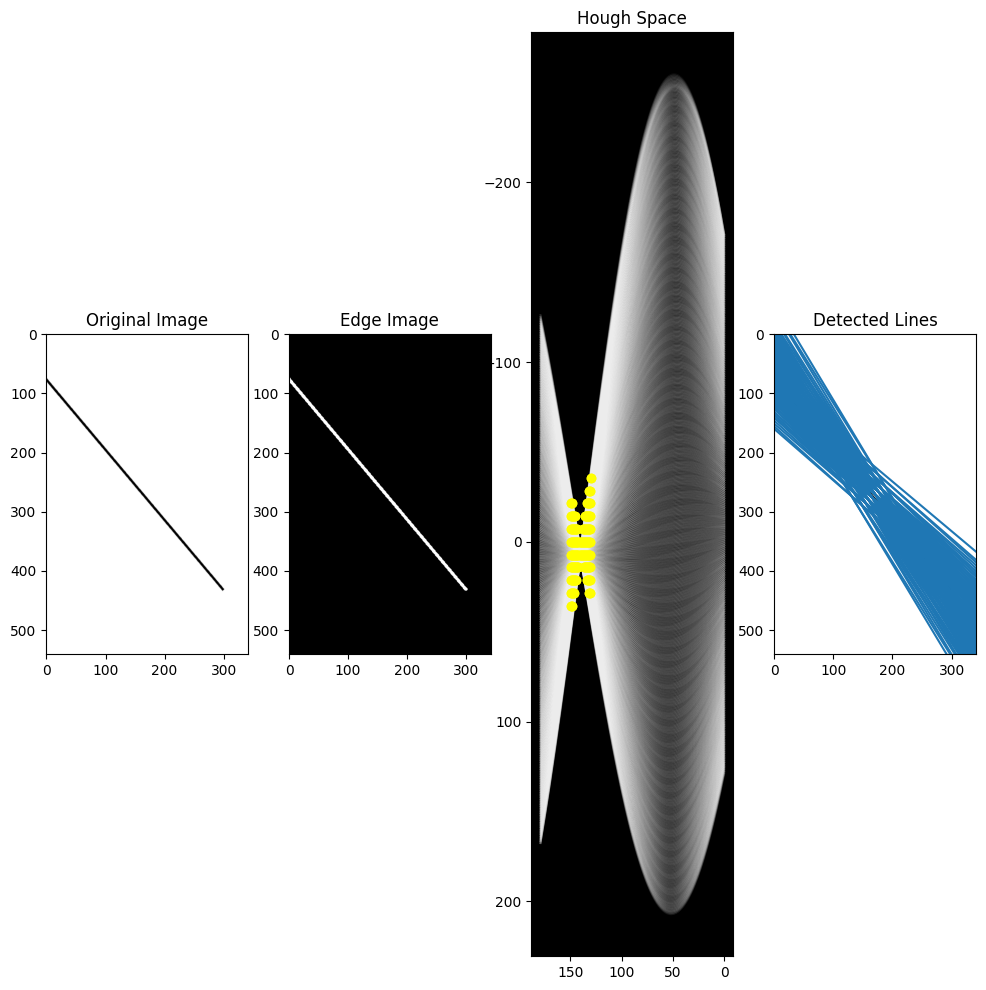

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-6.40880644e+02, -6.33759748e+02, -6.26638852e+02, -6.19517956e+02,
        -6.12397060e+02, -6.05276164e+02, -5.98155268e+02, -5.91034372e+02,
        -5.83913476e+02, -5.76792580e+02, -5.69671684e+02, -5.62550788e+02,
        -5.55429892e+02, -5.48308996e+02, -5.41188099e+02, -5.34067203e+02,
        -5.26946307e+02, -5.19825411e+02, -5.12704515e+02, -5.05583619e+02,
        -4.98462723e+02, -4.91341827e+02, -4.84220931e+02, -4.77100035e+02,
        -4.69979139e+02, -4.62858243e+02, -4.55737347e+02, -4.48616451e+02,
        -4.41495555e+02, -4.34374659e+02, -4.27253763e+02, -4.20132867e+02,
        -4.13011971e+02, -4.05891075e+02, -3.98770179e+02, -3.91649283e+02,
        -3.84528386e+02, -3.77407490e+02, -3.70286594e+02, -3.63165

In [62]:
image = cv2.imread("line_detection.png")
edge_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
edge_image = cv2.GaussianBlur(edge_image, (3, 3), 1)
edge_image = cv2.Canny(edge_image, 100, 200)
edge_image = cv2.dilate(
     edge_image,
    cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)),
     iterations=1
)
edge_image = cv2.erode(
  edge_image,
  cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)),
  iterations=1
)
line_detection_vectorized(image, edge_image)